In [ ]:
%%bash
git clone https://github.com/josepablocam/ai4code_repair.git
pushd ai4code_repair
source install.sh

In [ ]:
# make sure environment variable are setup in notebook
import os
grmtools_release_path = os.path.join(os.getcwd(), "ai4code_repair", "resources", "grmtools", "target", "release")
os.environ["PATH"] = os.environ["PATH"] + ":" + grmtools_release_path

In [ ]:
cd ai4code_repair

In [ ]:
%load_ext tensorboard

# Syntax Repair with Language Models

## Problem statement

## Dataset: DeepFix

In [181]:
!sqlite3 ./data/prutor-deepfix-09-12-2017.db ".schema Code"

CREATE TABLE IF NOT EXISTS "Code" (
	`code_id`	text,
	`user_id`	text,
	`problem_id`	text,
	`code`	text,
	`error`	text,
	`errorcount`	int,
	PRIMARY KEY(code_id)
);


In [182]:
!sqlite3 ./data/prutor-deepfix-09-12-2017.db "select count(*) from Code"

53478


In [183]:
!sqlite3 ./data/prutor-deepfix-09-12-2017.db "select count(distinct(user_id)) from Code"

840


In [184]:
!sqlite3 ./data/prutor-deepfix-09-12-2017.db "select errorcount > 0, count(*) from Code group by errorcount > 0"

0|46500
1|6978


## Preparing a dataset

* Synthetic data
* Telemetry data
* Combination

### Synthetically breaking correct programs

In [185]:
from repair.tutorial_utils import show_code
from scripts.create_data import add_noise
show_code(add_noise)

def add_noise(code: str) -> Tuple[str, str]:
    ops = [
        "remove-line",
        "replace-line",
        "remove-char",
        "replace-char",
        "insert-char",
    ]
    chosen_op = random.choice(ops)
    if chosen_op in {"remove-line", "replace-line"}:
        lines = code.split("\n")
        n = len(lines)
        ix1 = random.randint(0, n - 1)
        if chosen_op == "remove-line":
            new_lines = lines[:ix1] + lines[(ix1 + 1):]
        else:
            assert chosen_op == "replace-line"
            ix2 = random.randint(0, n - 1)
            new_lines = list(lines)
            new_lines[ix1] = new_lines[ix2]
        return chosen_op, "\n".join(new_lines)
    else:
        n = len(code)
        ix1 = random.randint(0, n - 1)
        new_code = ""
        if chosen_op == "remove-char":
            new_code = code[:ix1] + code[(ix1 + 1):]
        elif chosen_op == "replace-char":
            ix2 = random.randint(0, n - 1)
            new_chars = list(code)
            new_chars[ix1] = new_chars[ix2]
            new_code = "".join(new_chars)
        else:
            assert chosen_op == "insert-char"
            # just delimiters
            options = ["(", ")", "{", "}", ";", "."]
            new_char = random.choice(options)
            new_code = code[:ix1] + new_char + code[ix1:]

        return chosen_op, new_code

** Extension Task: Improve the noise operations to more resemble real mistakes **
* Reference: BIFI paper

In [186]:
from repair import utils
train = utils.get_train_data()
test = utils.get_test_data()

In [187]:
# number of buggy programs in training split
len(train)

5314

In [190]:
# number of programs in our test split (for benchmarking)
len(test)

5

In [188]:
from repair import utils
import tqdm
# distribution of length in terms of  program tokens (lexer --- note this is different from the underlying model tokenizers)
num_tokens = [len(utils.tokenize(b.source)) for b in tqdm.tqdm(train)]


100%|██████████| 5314/5314 [00:03<00:00, 1399.93it/s]


Text(0, 0.5, 'Count of cases')

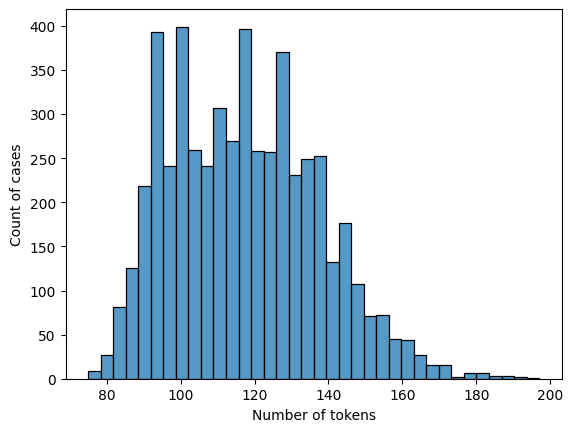

In [189]:
import seaborn as sns
ax = sns.histplot(num_tokens)
ax.set_xlabel("Number of tokens")
ax.set_ylabel("Count of cases")

Text(0, 0.5, 'Count of cases')

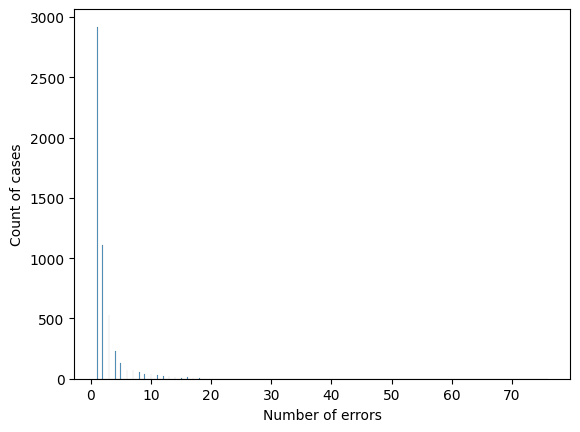

In [191]:
# distribution of number of compile errors
errorcounts = [b.errorcount for b in train]
ax = sns.histplot(errorcounts)
ax.set_xlabel("Number of errors")
ax.set_ylabel("Count of cases")

Text(0, 0.5, 'Number of compilation errors')

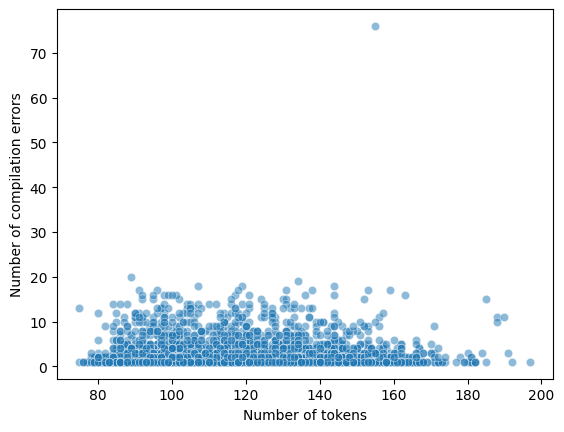

In [192]:
# Relationship between length and errors
ax = sns.scatterplot(x=num_tokens, y=errorcounts, alpha=0.5)
ax.set_xlabel("Number of tokens")
ax.set_ylabel("Number of compilation errors")

In [193]:
# random sample of k compile errors in training split
import random
k = 5
sampled = train[:k]
for i, case in enumerate(sampled):
    print("Sample", i)
    print(case.source)
    print("Error:", case.error)
    print("--------------")

Sample 0
#include <stdio.h>
#include <stdlib.h>
int main() {
	int n,i,t[1000],a,b,sum=0,j=1;
	scanf("%d",&n);
	for(i=0;i<n;i++)
	{
	  sanf("%d",&t[i]);
      for(i=0;i<(n-1)/2;i++)
	  {
	     if(t[i]<=t[(n-1)-i]);
	   sum=sum+j;
	    a=sum;
	    b=n-a;
	     printf("%d %d ",a,b);
	  }
	}
	return 0;
}
Error: /usr/bin/ld: /tmp/ccXBLQll.o: in function `main':
tmpi233v6m0.c:(.text+0x83): undefined reference to `sanf'
collect2: error: ld returned 1 exit status

--------------
Sample 1
#include <stdio.h>
int main()
{
    int n,m;
    int i,j,k;
    scanf("%d %d",&n,&m);
    int sum[n],row[m];
    for (i=0;i<n;i++){
for (j=1;j<=m;j++) {
int row[m];
s)anf("%d ",&row[j-1]);}
for (k=0;k<m;k++) {
     sum[i]=0;
     sum[i]=sum[i]+row[k];
}
    }
    return 0;
}
Error: /tmp/tmphvmu6v6_.c: In function ‘main’:
/tmp/tmphvmu6v6_.c:11:1: error: ‘s’ undeclared (first use in this function)
   11 | s)anf("%d ",&row[j-1]);}
      | ^
/tmp/tmphvmu6v6_.c:11:1: note: each undeclared identifier is reported onl

In [194]:
# random sample of k compile errors in test split
test = utils.get_test_data()
k = 5
sampled = test[:k]
for i, case in enumerate(sampled):
    print("Sample", i)
    print(case.source)
    print("Error:", case.error)
    print("--------------")

Sample 0
#include <stdio.h>

int main()
{
    int m,n,count=0;
    scanf("%d%d",&m,&n);
    for(i=2;i<n;i++)
    {
        if(n%i==0)
        count++;
    }
    if(count==m)
    printf("YES");
    else
    printf("NO");
    return 0;
}
Error: In function ‘main’:
7:9: error: ‘i’ undeclared (first use in this function)
     for(i=2;i<n;i++)
         ^
7:9: note: each undeclared identifier is reported only once for each function it appears in
--------------
Sample 1
#include<stdio.h>
long int product(int a[],int n);
int main()
{
    int N,i,p;
    scanf("%d\n",&N);
    int a[N];
    for(i=0;i<N;i++)
    scanf("%d",&a[i]);
    p=product (a,N);
    printf("%ld",p);
    
    return 0;
}
long int product (int a[],int n)
{
    if (n==0)
    return a[0];
    return (a[n-1]*product(int a[],n-1);
    
}
Error: In function ‘product’:
19:28: error: expected expression before ‘int’
     return (a[n-1]*product(int a[],n-1);
                            ^
19:20: error: too few arguments to function ‘pr

## Metrics

Goal: compilability -- but also, how far from original user intent? E.g. can delete all source code to yield (empty) compilable unit

In [195]:
bad_simple = "int main( {return 0;}"
ok_simple = "int main() {return 0;}"

In [196]:
utils.gcc_compile(bad_simple)

CompileResult(ok=False, error='/tmp/tmp1xkp_8mq.c:1:11: error: expected declaration specifiers or ‘...’ before ‘{’ token\n    1 | int main( {return 0;}\n      |           ^\n', errorcount=1)

In [197]:
utils.gcc_compile(ok_simple)

CompileResult(ok=True, error=None, errorcount=0)

In [198]:
# typically: satisfy oracle (i.e. compiler) but also need to limit edit distance (e.g. deleting everything yields compilable unit)
# token edit distance: standard levenshtein distance but on lexer outputs (better than simple string distance)
utils.token_edit_distance(
    bad_simple,
    ok_simple
)

1.0

In [199]:
# can also use tree edit distance with parse tree that maintains syntax errors
utils.tree_edit_distance(
    bad_simple,
    ok_simple
)

1.0

** Extension task: find interesting examples where token-based distance is quite different from tree-edit distance. Which is more intuitive? Does it depend on case? ** 

## Running benchmarks

In [205]:
# Our basic datatype
train[0]

RepairTaskRecord(code_id='prog08972', user_id='user593', problem_id='prob79', source='#include <stdio.h>\n#include <stdlib.h>\nint main() {\n\tint n,i,t[1000],a,b,sum=0,j=1;\n\tscanf("%d",&n);\n\tfor(i=0;i<n;i++)\n\t{\n\t  sanf("%d",&t[i]);\n      for(i=0;i<(n-1)/2;i++)\n\t  {\n\t     if(t[i]<=t[(n-1)-i]);\n\t   sum=sum+j;\n\t    a=sum;\n\t    b=n-a;\n\t     printf("%d %d ",a,b);\n\t  }\n\t}\n\treturn 0;\n}', error="/usr/bin/ld: /tmp/ccXBLQll.o: in function `main':\ntmpi233v6m0.c:(.text+0x83): undefined reference to `sanf'\ncollect2: error: ld returned 1 exit status\n", errorcount=1, target='#include <stdio.h>\n#include <stdlib.h>\nint main() {\n\tint n,i,t[1000],a,b,sum=0,j=1;\n\tscanf("%d",&n);\n\tfor(i=0;i<n;i++)\n\t{\n\t  scanf("%d",&t[i]);\n      for(i=0;i<(n-1)/2;i++)\n\t  {\n\t     if(t[i]<=t[(n-1)-i]);\n\t   sum=sum+j;\n\t    a=sum;\n\t    b=n-a;\n\t     printf("%d %d ",a,b);\n\t  }\n\t}\n\treturn 0;\n}')

In [204]:
show_code(utils.run_benchmark)

def run_benchmark(system: BenchmarkRunner, **kwargs):
    test_data = get_test_data()
    predicted = system.run_benchmark(test_data, **kwargs)
    buggy = [t.source for t in test_data]
    annot = run_basic_annotation(predicted, buggy)
    summary = basic_results_table(annot)
    return summary, annot

In [220]:
# Dummy run
from typing import List
from repair.utils import BenchmarkRunner, RepairTaskRecord
class JoseBadRepair(utils.BenchmarkRunner):
    def run_benchmark(self, cases: List[RepairTaskRecord]):
        # single dummy repair for each case
        return [["int main(){return 0;}"]] * len(cases)

In [221]:
utils = reload(utils)
result = utils.run_benchmark(JoseBadRepair())

In [225]:
result[1][0]

[PredictionAnnotation(prediction='int main(){return 0;}', buggy='#include <stdio.h>\n\nint main()\n{\n    int m,n,count=0;\n    scanf("%d%d",&m,&n);\n    for(i=2;i<n;i++)\n    {\n        if(n%i==0)\n        count++;\n    }\n    if(count==m)\n    printf("YES");\n    else\n    printf("NO");\n    return 0;\n}', compile_result=CompileResult(ok=True, error=None, errorcount=0), distance=77.0)]

## Repairing compile errors with CodeT5

### CodeT5 Overview

### Zero-shot repair with CodeT5

* Repair as cloze-style task: reference https://arxiv.org/pdf/2207.08281.pdf

In [255]:
from repair.engines import codet5

In [256]:
show_code(codet5.CodeT5ClozeRepair)

class CodeT5ClozeRepair(RepairEngine, BenchmarkRunner):
    """
    https://arxiv.org/pdf/2207.08281.pdf
    """
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained('Salesforce/codet5-base')
        self.model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base')

    def _localize_line(self, code):
        result = gcc_compile(code)
        if result.ok:
            raise Exception("To localize must have compile error")

        line_regex = re.compile(".c:([0-9]+):[0-9]+")
        matches = line_regex.findall(result.error)
        # turn to 0-indexed
        line_nums = set(int(m) - 1 for m in matches)
        if len(line_nums) == 0:
            # default to first line
            # FIXME: better fall back
            return [0]
        return line_nums
        
    
    def _add_code_masks(self, code):
        # FIXME: extend to not mask whole line
        # but just range indicated by error message
        line_nums = self._localize_line(code)
        lines = code.split("\n")
        mask_tokens = []
        for ix, l_ix in enumerate(line_nums):
            mask_token = f"<extra_id_{ix}>"
            lines[l_ix] = mask_token #+ ";"
            mask_tokens.append(mask_token)
        return ["\n".join(lines), mask_tokens]

    def _decoded_to_mask_tokens_map(self, decoded: str, mask_tokens: List[str]):
        mapping = {}
        for mask_token in mask_tokens:
            start_ix = decoded.find(mask_token)
            # offset by length of mask itself
            start_ix += len(mask_token)
            end_ix = decoded[start_ix:].find("<extra_id_")
            if end_ix >= 0:
                mask_value = decoded[start_ix:(start_ix + end_ix)]
            else:
                # rest of string
                mask_value = decoded[start_ix:]
            # remove any special tokens
            special_tokens = [self.tokenizer.eos_token, self.tokenizer.pad_token]
            for special_tok in special_tokens:
                mask_value = mask_value.replace(special_tok, "")
            mapping[mask_token] = mask_value
        return mapping

    def _decode_code_with_cloze(self, code: str, mask_token_map: Dict[str, str]):
        for token_name, token_value in mask_token_map.items():
            code = code.replace(token_name, token_value)
        return code

    def repair(self, code: str, **kwargs):
        # Replace entire line that has error
        # extract line from errormessage
        new_code, mask_tokens = self._add_code_masks(code)
        encoded_inputs = self.tokenizer(
            new_code,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
        ).to(get_torch_device())
        # FIXME: we can set the average length of mask_token to be average length
        # of each line tokenized
        generated = self.model.generate(
            **encoded_inputs, 
            max_length=20 * len(mask_tokens),
            num_beams=kwargs.get("num_beams", 3),
            # default to as many as beam size
            num_return_sequences=kwargs.get("num_return_sequences", kwargs.get("num_beams", 3)),
            early_stopping=kwargs.get("early_stopping", True),
        )
        results = []
        for seq in generated:
            decoded = self.tokenizer.decode(seq, skip_special_tokens=False)
            mask_token_map = self._decoded_to_mask_tokens_map(decoded, mask_tokens)
            filled_code = self._decode_code_with_cloze(new_code, mask_token_map)
            results.append({"repair": filled_code})
        return results

In [257]:
cloze_t5 = codet5.CodeT5ClozeRepair()

In [261]:
some_repair = cloze_t5.repair(test[0].source, num_beams=3)[0]['repair']

In [262]:
print(utils.diff(test[0].source, some_repair))

@@ -4,7 +4,7 @@
 {
     int m,n,count=0;
     scanf("%d%d",&m,&n);
-    for(i=2;i<n;i++)
+for(int i=0;i<m;i++)
     {
         if(n%i==0)
         count++;



In [ ]:
res = utils.run_benchmark(cloze_t5, verbose=True)
print(res[0])

In [ ]:
## Larger model
cloze_t5_base = codet5.CodeT5ClozeRepair("Salesforce/codet5-base")
res = utils.run_benchmark(cloze_t5_base, verbose=True)
print(res[0])

### Fine-Tuned repair with CodeT5

In [ ]:
checkpoint_path = "resources/c5.finetuned.bin"
codet5.CodeT5FineTunedRepair().finetune(
    train[:1],
    batch_size=1,
    num_epochs=1
    checkpoint_path=checkpoint_path
)


In [ ]:
# load checkpoint
c5_finetuned = codet5.CodeT5FineTunedRepair(checkpoint_path)
c5_finetuned.repair(bad_simple)

In [ ]:
res = utils.run_benchmark(c5_finetuned)
res[0]

** Extension task: continue fine-tuning the latest checkpoint, see if performance improves

** Extension task: try fine-tuning on a different language (see data/ for options)

## Parser Error Recovery: GRMTOOLS

## Fixing Syntax Errors with Codex

### Codex Overview

In [ ]:
# Reference and explain https://arxiv.org/abs/2208.11640

In [ ]:
from repair.engines import codex

In [ ]:
show_code(codex.CodexEngine)

class CodexEngine(object):

    def __init__(
        self,
        openai_key: str,
        temperature: float = 0,
        n: int = 1,
        maxtokens: int = 200,
        stop: str = "///",
        engine: str = "code-davinci-002",
    ):
        openai.api_key = openai_key
        self.temperature = temperature
        self.maxtokens = maxtokens
        self.n = n
        self.top_p = 1.0
        self.presence_penalty = 0.0
        self.frequency_penalty = 0.0
        self.stop = stop
        self.engine = engine

    def complete(self, prompt: str, **kwargs):
        try:
            response = openai.Completion.create(
                engine=self.engine,
                prompt=prompt,
                max_tokens=kwargs.get("maxtokens", self.maxtokens),
                temperature=kwargs.get("temperature", self.temperature),
                top_p=kwargs.get("top_p", self.top_p),
                presence_penalty=kwargs.get("presence_penalty",
                                            self.presence_penalty),
                frequency_penalty=kwargs.get("frequency_penalty",
                                             self.frequency_penalty),
                stop=kwargs.get("stop", self.stop),
                n=kwargs.get("n", self.n),
                logprobs=1,
            )
            unsorted_completions = [
                (completion["text"],
                 np.mean(completion["logprobs"]["token_logprobs"]))
                for completion in response["choices"]
            ]

            # higher average prob should come first
            sorted_completions = sorted(unsorted_completions,
                                        key=lambda x: x[1],
                                        reverse=True)
            result_dicts = []
            for completion_txt, avg_logprob in sorted_completions:
                result_dicts.append({
                    "completion": completion_txt,
                    "avg_logprob": avg_logprob,
                })
            return result_dicts
        except Exception as e:
            print("Skipping exception")
            print(e)
            return None

### Base Codex: simple prompt and buggy program

In [ ]:
show_code(codex.CodexBaseRepair)

class CodexBaseRepair(CodexRepair):
    """
    Based on https://beta.openai.com/examples/default-fix-python-bugs
    """

    def __init__(self, *args, **kwargs):
        self.codex = CodexEngine(*args, **kwargs)

    def get_prompt(self, code: str, **kwargs) -> str:
        # Based on https://beta.openai.com/examples/default-fix-python-bugs
        prompt = """//// Fix bugs in the below code\n"""
        prompt += f"/// Buggy C\n{code}\n\n"
        prompt += "/// Fixed C"
        if 'fixed' in kwargs and kwargs['fixed'] is not None:
            prompt += f"\n{kwargs['fixed']}\n\n"

        return prompt

    def get_repair_from_completion_(
            self, completion_dict: Dict[str, Any]) -> Dict[str, Any]:
        comp = completion_dict["completion"]
        # remove first \n and last \n, result from our prompt style
        if comp[0] == "\n":
            comp = comp[1:]
        if comp[-1] == "\n":
            comp = comp[:-1]
        return {"repair": comp, "score": completion_dict["avg_logprob"]}

    def deduplicate_repairs_(
            self, repair_dicts: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        unique_repair_dicts = []
        already_included = set()
        for rd in repair_dicts:
            repair_str = rd["repair"]
            if repair_str not in already_included:
                unique_repair_dicts.append(rd)
                already_included.add(repair_str)
        return unique_repair_dicts

    def repair(self, code: str, **kwargs):
        # FIXME: warn if number of tokens too few for length of code
        # or set to num tokens + K
        # Use: https://github.com/openai/tiktoken , which is fast openai tokenizer
        # to estimate tokens for code and pass in as maxtokens=<val>
        prompt = self.get_prompt(code, **kwargs)
        completion_dicts = self.codex.complete(prompt, **kwargs)
        if completion_dicts is None:
            return []

        repair_dicts = [
            self.get_repair_from_completion_(c) for c in completion_dicts
        ]
        repair_dicts = self.deduplicate_repairs_(repair_dicts)
        return repair_dicts

In [ ]:
import os
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [ ]:
codex_base = codex.CodexBaseRepair(OPENAI_API_KEY)

In [ ]:
pred = codex_base.repair(test[0].source, n=1)
pred

[{'repair': '#include <stdio.h>\n\nint main()\n{\n    int m,n,count=0,i;\n    scanf("%d%d",&m,&n);\n    for(i=2;i<n;i++)\n    {\n        if(n%i==0)\n        count++;\n    }\n    if(count==m)\n    printf("YES");\n    else\n    printf("NO");\n    return 0;\n}\n',
  'score': -0.04469034889016239}]

In [ ]:
res = utils.run_benchmark(codex_base, n=1)
res[0]

100%|██████████| 5/5 [00:25<00:00,  5.13s/it]


,stat,top-1,top-3,top-5
0,compile,1.0,1.0,1.0
1,compile+distance,0.8,0.8,0.8


### Add error message to improve error localization

What is error localization? Long history in APR. Describe

In [ ]:
show_code(codex.CodexWithErrorInfo)

class CodexWithErrorInfo(CodexBaseRepair):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.error_cache = {}

    def _get_error_info(self, code: str) -> str:
        if code not in self.error_cache:
            self.error_cache[code] = gcc_compile(code).error
        return self.error_cache[code]

    def get_prompt(self, code: str, **kwargs):
        prompt = """//// Fix bugs in the below code\n"""
        prompt += f"/// Buggy C\n{code}\n\n"
        error_msg = self._get_error_info(code)
        prompt += f"/// Error Message\n{error_msg}\n\n"
        prompt += "/// Fixed C"
        if 'fixed' in kwargs and kwargs['fixed'] is not None:
            prompt += f"\n{kwargs['fixed']}\n\n"

        return prompt

In [ ]:
codex_msg = codex.CodexWithErrorInfo(OPENAI_API_KEY)

In [ ]:
pred = codex_msg.repair(test[0].source, n=1)
pred

[{'repair': 'ode\n#include <stdio.h>\n\nint main()\n{\n    int m,n,count=0,i;\n    scanf("%d%d",&m,&n);\n    for(i=2;i<n;i++)\n    {\n        if(n%i==0)\n        count++;\n    }\n    if(count==m)\n    printf("YES");\n    else\n    printf("NO");\n    return 0;\n}',
  'score': -0.08690995497276068}]

In [ ]:
res =  utils.run_benchmark(codex_msg, n=1)
res[0]

100%|██████████| 5/5 [00:26<00:00,  5.20s/it]


Skipping exception
Rate limit reached for default-code-davinci-002 in organization org-0dl5WSUnJjIQPKFDFDgy9jNn on requests per min. Limit: 20.000000 / min. Current: 30.000000 / min. Contact support@openai.com if you continue to have issues.


,stat,top-1,top-3,top-5
0,compile,0.4,0.4,0.4
1,compile+distance,0.4,0.4,0.4


### Add few-shots to help show what kind of edits may be needed

What are few-shots? Why helpful for prompt-based learning (in-context learning)?

Some ways to pick:
* Fixed (manually curated)
* Random (from an example bank)
* Smart (which some metric for similarity)

### Side-excursion: Creating an example bank
** Extension task: create a better example bank. Can you create/collect better examples by using existing repair model? ** (another BIFI reference)

### Back to few-shots

In [ ]:
show_code(codex.CodexWithFewShots)

class CodexWithFewShots(CodexBaseRepair):

    def __init__(self, shot_selector: FewShotSelector, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.shot_selector = shot_selector
        self.prompt_helper = CodexWithErrorInfo(*args, **kwargs)

    def get_prompt(self, code: str, **kwargs):
        few_shots = self.shot_selector.select_shots(code, kwargs.get("k", 3))
        prompt = ""
        for shot in few_shots:
            prompt += self.prompt_helper.get_prompt(shot.source,
                                                    fixed=shot.target)

        prompt += self.prompt_helper.get_prompt(code)
        return prompt

In [ ]:
example_bank = train[:30]
fixed_shot_selector = codex.FixedFewShots(example_bank)
random_shot_selector = codex.RandomFewShots(example_bank)

In [ ]:
show_code(codex.SimilarityFewShots)

class SimilarityFewShots(FewShotSelector):

    def __init__(self, example_bank: List[RepairTaskRecord], verbose=False):
        self.example_bank = list(example_bank)
        self.embedder = CodeBertEmbedder()
        if not verbose:
            self.embedded_bank = self._get_norm_embedding([e.source for e in self.example_bank])
        else:
            # WARNING: just for debugging/seeing progress...
            res = [self._get_norm_embedding([e.source]) for e in tqdm.tqdm(self.example_bank)]
            self.embedded_bank = np.vstack(res)

    def _get_norm_embedding(self, programs: List[str]) -> np.ndarray:
        vectors = self.embedder.embed(programs).numpy()
        normed_vectors = vectors / np.linalg.norm(vectors, ord=2, axis=1).reshape(-1, 1)
        return normed_vectors

    def _retrieve_nearest_k_ixs(self, vec: np.ndarray, k: int) -> List[int]:
        # FIXME: replace with a fast approximate search engine like FAISS to scale
        scores = np.matmul(self.embedded_bank, vec.T).flatten()
        top_ixs = np.argsort(scores)[-k:]
        return top_ixs

    def select_shots(self, code: str, k: int) -> List[RepairTaskRecord]:
        vec = self._get_norm_embedding([code])
        ixs = self._retrieve_nearest_k_ixs(vec, k)
        chosen = [self.example_bank[i] for i in ixs]
        return chosen

In [ ]:
from repair import codesimilarity
show_code(codesimilarity.CodeBertEmbedder)

class CodeBertEmbedder(object):

    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained(
            "microsoft/codebert-base")
        self.model = AutoModel.from_pretrained("microsoft/codebert-base")
        self.model = self.model.to(get_torch_device())
        self.model.eval()
        self.cache_compile_results = {}

    def prepare_msg_input(self, msg: str):
        # FIXME: better preparation (e.g. distinguish between NL/code)
        return msg

    def embed_compile_results(self, compile_results: List[CompileResult]):
        """
        following https://github.com/microsoft/CodeBERT
        """
        if isinstance(compile_results, CompileResult):
            compile_results = [compile_results]

        msgs = [r.error for r in compile_results]
        if any(m is None for m in msgs):
            raise Exception("Embedding compiler error message requires error")

        txt_inputs = [self.prepare_msg_input(m) for m in msgs]
        encoded_inputs = self.tokenizer(
            txt_inputs,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
        ).to(get_torch_device())
        with torch.no_grad():
            result = self.model(**encoded_inputs)
        # aggregate with average
        # FIXME: consider other approaches to aggregating or using pooled output
        embeddings = result[0].mean(dim=1)
        return embeddings

    def embed(self, programs: List[str]):
        msgs = []
        for prog in programs:
            if prog not in self.cache_compile_results:
                self.cache_compile_results[prog] = gcc_compile(prog)
            msgs.append(self.cache_compile_results[prog])
        return self.embed_compile_results(msgs)

In [ ]:
sim_shot_selector = codex.SimilarityFewShots(example_bank, verbose=True)

100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


In [ ]:
codex_shots = codex.CodexWithFewShots(sim_shot_selector, OPENAI_API_KEY)

In [ ]:
res =  utils.run_benchmark(codex_shots, n=1, k=2)
res[0]

100%|██████████| 5/5 [00:29<00:00,  5.90s/it]


,stat,top-1,top-3,top-5
0,compile,0.8,0.8,0.8
1,compile+distance,0.8,0.8,0.8


### (Some) Parameters that affect repair with Codex

* Temperature: consider varying values and see different performance (higher temperatures can provide more diverse repairs)
* Number of candidates sampled
* Of course, the prompt
* Type of sampling: nucleus sampling vs temperature sampling

### More extension tasks with Codex
* Repair iteratively (if have more than one mistake): reference JIALU paper
* Send smaller context around error location (faster and can avoid spurious changes)
* CodeBERT similarity was out-of-the-box, but what if we tune for repair? TST reference here
* Scale the size of the example bank
* Implement better (not just average token logprobs) ranking: reference Jeevana paper

###